In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import curve_fit
import scipy.signal as spy
import glob
import time
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import imageio
import moviepy.editor as mpy
print(time.ctime())
#%matplotlib notebook
%matplotlib inline
#import mpld3

#mpld3.enable_notebook()

#This module takes all unsorted files (1296) in a single directory & sorts them, then calculates 81 S values
# Once all those S values are saved, it outputs them in a graphic
# You'll need that bash file, or your own method to download all the .csv files
# Commenting does exist, but if something doesn't make sense, check the module it is referencing
# I tried to institute Hungarian Notation, where the first letter of each variable relates to the datatype 
# it should be. (l_ means list, a_ means array, s_ means string) 
# This notation isn't used in a lot of the modules because they were written earlier in the summers

Fri Sep 21 11:06:31 2018


In [2]:
#functions
def linear(x,a,b):
    return x*a + b
def exp_decay(x,a,b,c):
    return a * np.exp(-b*x) + c
def root(x,a,b):
    return a *np.sqrt(x) + b
def fitting(function,xdata,ydata,  guess,sigma = 0):
    if type(sigma) is int:
        fit_opt, fit_cov = curve_fit(function,xdata,ydata, p0=guess, maxfev = 2600)
    else:
        fit_opt, fit_cov = curve_fit(function,xdata,ydata, p0=guess, sigma = sigma, absolute_sigma = True)
    return function(xdata,*fit_opt), fit_opt, fit_cov 
def gaussian(x, amp, cen, wid,const):
    return amp * np.exp(-(x-cen)**2 / wid)+const
def polygauss(x,amp,cen,wid,am2,cen2,wid2,const):
    return gaussian(x, amp, cen, wid,const) + gaussian(x,am2, cen2, wid2,const)
def polyexpo(x,a,b,c,d):
    return exp_decay(x,a,b) + exp_decay(x,c,d)
def expogauss(x,a,b,c,d, amp,cen,wid):
     return polyexpo(x,a,b,c,d) + gaussian(x, amp, cen, wid)
def sin(x,a,b,c,d):
    value = a*np.sin((x*(2*np.pi/b)+(180/np.pi)*c))+d
    return value
def chi_square_red(x, y, yerr, modelfunc, p_opt):
    numerator = (y - modelfunc(x, *p_opt)) ** 2
    denominator = yerr ** 2
    chi = sum(numerator / denominator)
    chired = chi / (len(y) - len(p_opt))
    return chired

In [3]:
def data_gather(filelist,directory):
        delta = []                                                  # generates new empty lists
        coi = []
        fiber = []
        for i in range(len(filelist)):
            s_file = directory+filelist[i]
            data = np.loadtxt(s_file, dtype= float, delimiter=",", usecols = (0,1,2))   # loads data
            deltafill = data[:, 0]                                                          # places data in separate arrays
            coifill = data[:, 1]
            fiberfill = data[:,2]
            # places arrays into a Python list
            delta.append(deltafill)
            coi.append(coifill)
            fiber.append(fiberfill)
        return delta,coi,fiber

In [4]:
def GaussianFit(delta,coi, fiber,name,pol,init = (2500,0,40,2500,0,60,150),init3 =  (1000,0,50,800,0,80,1500)):
    param3 = init3
    cutd, cutc, cutf = fiberselect(delta,coi,fiber,1)
    newd, newc,newf = fiberselect(delta,coi,fiber,2)
    if np.max(coi) < 50:
        guess = (250,0,40,15)
        print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    #fit2 = fitting(polygauss,cutd, cutf,guess = init3)
    #fit3 = fitting(polygauss,newd,newf, guess = init3 )
    cutd = np.sort(cutd)
    newd = np.sort(newd)   
    # calculating integral and error propogation
    param = fit[1]
    #param2 = fit2[1]
    #param3 = fit3[1]
       # integrals
    if np.max(coi) < 50:
        total = param[0]*np.sqrt(np.pi*(param[2]))

    else:
        total = param[0]*np.sqrt(np.pi*(param[2])) + param[3]*np.sqrt(np.pi*param[5]) 
    #total2 =(param2[0]*np.sqrt(np.pi*(param2[2])) + param2[3]*np.sqrt(np.pi*param2[5])) /2 
    #total3 = (param3[0]*np.sqrt(np.pi*(param3[2])) + param3[3]*np.sqrt(np.pi*param3[5]))/2 
    # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]))
    #perr2 = np.sqrt(np.diag(fit2[2]))
    #perr3 = np.sqrt(np.diag(fit3[2]))
    # error propogation
    if np.max(coi) < 50:
        se = total*np.sqrt(perr[0]/param[0]**2)+ param[3]           
    else:
        se =total*np.sqrt((perr[0]/param[0])**2+(perr[2]/(2*param[2])**2))
    #se2 = total2*np.sqrt((perr2[0]/param2[0])**2+(perr2[2]/(2*param2[2])**2))
    #se3 = total3*np.sqrt((perr3[0]/param3[0])**2+(perr3[2]/(2*param3[2])**2))
    #if np.isinf(se3) == True:
        #print(pol)
        #print(param3)
        #print(perr3)
    # Plotting functionality
    fig,ax = plt.subplots(figsize = (10,10))
    #plt.scatter(delta,fiber, marker = "+",color = 'lightcoral' ,alpha = 0.5)
    plt.scatter(delta, coi,marker = "+", color = 'cadetblue', )
    plt.plot(delta, fit[0], color = 'm', label = 'Coincidences' )
    #plt.plot(cutd[:np.int(len(cutd)/2)], fit2[0][:np.int(len(cutd)/2)],color = 'gold', label = 'Coincidences - Same Fiber' )
    #plt.plot(newd[np.int(len(newd)/2+1):], fit3[0][np.int(len(newd)/2+1):],color = 'orange', label = 'Coincidences - Same Fiber2')
    plt.title('Coincidences ' + pol)
    #plt.ylim(0,3150)
    plt.xlim(-50,50)
    plt.xlabel('Delta T (ns)')
    plt.ylabel('Coincidences')
    plt.legend()
    textstr = '$Coincidences=%.2f$'% (total)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    #plt.savefig(name,  bbox_inches='tight')
    return total, se, param, param3



In [5]:
def fiberselect(d, c, f,fiber):
    #this is used in the GaussianFit module. It is how I fit the two separate fibers (+/- 0)
    if fiber == 1:
        index = np.where(d <= 0)
        newindex = np.where(d < 0)
        delta_part = d[index]
        delta =np.append(delta_part, -1*d[newindex] )
    if fiber == 2:
        index = np.where(d >= 0)
        newindex = np.where(d > 0)
        delta_part = -1*d[index]
        delta =np.append(delta_part, d[newindex] )
    coi_part   = c[index]
    fiber_part = f[index]
    coi   =np.append(coi_part, c[newindex])
    fiber = np.append(fiber_part,f[newindex])
    return delta, coi, fiber

In [6]:
def fixer(parameters):
    # this just switches signs of things so I have positive amplitudes.
    #  It also plots just to check that the parameters I have make sense
    x = np.linspace(60,300,60)
    plt.figure(figsize =(20,10))
    plt.subplot(121)
    for i in range(4):
        plt.plot(x,sin(x,*parameters[i*4:(i*4+4)]))
    plt.show
    print(parameters)
    for i in range(0,4):
        if parameters[i*4] < 0:
            print(parameters[i*4])
            parameters[i*4] = np.absolute(parameters[i*4])
            parameters[4*i+2] = -parameters[((4*i)+2)]  
            parameters[4*i+1] = -parameters[((4*i)+1)]   
    print(parameters)
    plt.subplot(122)
    for i in range(4):
        plt.plot(x,sin(x,*parameters[i*4:(i*4+4)]))
    plt.show()                                              
    return(parameters)

In [7]:
def Sval(a_total):
    # Bell Inequality s values
    E = np.zeros(4)
    index = np.array([10,6,8,4,11,7,9,5,14,2,12,0,15,3,13,1])
    # I wish I could explain the index better. Once you sort the names of the files 'alphabetically'
    # then this sorts them into an order where each group of four represents an "E" to be calculated
    # Which ones belong to E are determined by orthogonality & described in the booklet for the photon source
    a_total = np.array(a_total)
    C = a_total[index]
    for i in range(len(C)):
        if np.isnan(C[i]) == True:
            print(i, 'C FUCKED UP') # pardon my french
        if np.isinf(C[i]) == True:
            print(i, 'C FUCKED UP INF')
    for i in range(4):
        num = C[4*i]-C[4*i+1]-C[4*i+2]+C[4*i+3]
        den = (C[4*i]+C[4*i+1]+C[4*i+2]+C[4*i+3])
        E[i] = num/den
        #print(den)
        #print(i)
    #print(E, "E")
    S = E[0]+E[1]-E[2]+E[3]
    print(S)
    max = 2*np.sqrt(2)
    #print(max)
    return S,C,E

In [8]:
def errorprop(C,E,errors):
# Error Propogation for each C
    coi_err = np.zeros(16)
    E_err = np.zeros(4)
    x = np.array([22.5,67.5,112.5,157.5])
    index = np.array([10,6,8,4,11,7,9,5,14,2,12,0,15,3,13,1]) 
    errors = np.array(errors)
    coi_err = errors[index]
    print(np.sum(coi_err), 'NAN SUM TEST')
    if np.isnan(np.sum(coi_err)) == True:
        print('Coincidence fucked up')
    for i in range(4):
        num = C[4*i]-C[4*i+1]-C[4*i+2]+C[4*i+3]
        den = (C[4*i]+C[4*i+1]+C[4*i+2]+C[4*i+3])
        num_err = np.sqrt(coi_err[4*i]**2+coi_err[4*i+1]**2+coi_err[4*i+2]**2+coi_err[4*i+3]**2)
        den_err = np.sqrt(coi_err[4*i]**2+coi_err[4*i+1]**2+coi_err[4*i+2]**2+coi_err[4*i+3]**2)
        if np.isnan(num_err) == True:
            print( 'NUM FUCKED UP ')
        if np.isnan(den_err) == True:
            print( 'DEN FUCKED UP ')
        E_err[i] = E[i]*np.sqrt((num_err/num)**2+(den_err/den)**2)
        if np.isnan(E_err[i]) == True:
            print( 'E FUCKED UP ')
    #Error Propogation in S
    print(E,E_err, 'E & error')
    S_err = np.sqrt((E_err[0]**2)+(E_err[1]**2)+(E_err[2]**2)+(E_err[3]**2))
    if np.isnan(S_err) == True:
        print('S FUCKED UP')
    print(S_err)
    return(S_err)

In [9]:
def CoincidenceCount(delta,coi,fiber,pol):
    index = np.where((delta < -100) | (delta > 100))
    cutd, cutc, cutf = fiberselect(delta,coi,fiber,1)
    newd, newc,newf = fiberselect(delta,coi,fiber,2)
    sameindex1 = np.where((cutd < -100) | (cutd > 100))
    sameindex2 = np.where((newd < -100) | (newd > 100))
    bkgavg = np.mean(coi[index])
    oneavg = np.mean(cutf[sameindex1])
    twoavg = np.mean(newf[sameindex2])
    total = np.sum(coi)-bkgavg*len(coi)
    #total = np.sum(coi-bkgavg)
    total1 = np.sum(cutf)-oneavg*len(coi)
    total2 = np.sum(newf)-twoavg*len(coi)
    '''
    dexter = np.where((delta > -50) & (delta < 50))
    dexter1 = np.where((cutd > -100) & (cutd < 100))
    dexter2 = np.where((newd > -100) & (newd < 100))
    othertot = np.sum(coi[dexter])
    othertot1 = np.sum(cutf[dexter1])
    othertot2 = np.sum(newf[dexter2])
    '''
    #print(total, pol)
    return total, total1, total2

In [10]:
directory = "/home/andrew/Documents/BNL 2018/Data/Scalc/"
l_file=os.listdir(directory)
l_filesort = []
l_label = []
print(len(l_file))
for i in range (3):
    for j in range(3):
        for k in range (3):
            for l in range (3):
                    str_i = str(i)
                    str_j = str(j)
                    str_k = str(k)
                    str_l = str(l)
                    s_labelfill = str_i+'x'+str_j+'_'+str_k+'x'+str_l
                    l_label.append(s_labelfill)
                    for m in range(len(l_file)):   
                        if l_file[m].endswith(str_i+'x'+str_j+'_'+str_k+'x'+str_l+'.csv'):
                            l_filesort.append(l_file[m])
                        
# This cell is rather messy, but it gives me labels and sorts all the file names 
# if you dumped all 1296 files into a single directory. I'll also supply the bash script that does that. 

1312


In [11]:
l_S = []
l_S_error = []
#for i in range(40,41):
for i in range(0,len(l_filesort)//16):
    l_filelist = l_filesort[i*16:16*i+16]   
    a_delta, a_coi, a_same = data_gather(l_filelist,directory)
    #print(len(a_delta))
    l_pol = []
    for k in range(len(l_filelist)):
        s_named = l_filelist[k]
        l_pol.append(s_named[4:14])
    #a_test = np.column_stack((l_filelist, l_pol))
    #print(a_test)
    a_total= np.empty(len(a_delta))
    a_error = np.empty(len(a_delta))
    a_first = np.empty(len(a_delta))
    a_firsterror = np.empty(len(a_delta))
    a_second = np.empty(len(a_delta))
    a_seconderror = np.empty(len(a_delta))
    a_param = (200,0,50,20,4,40,30)
    a_param3 = (220,0,40,220,0,60,30),
    # parameters are of form (amplitude, center, width, amp2, cent2, wid2, offset)
    # this means the offset is actually double this parameter, because each gaussian uses it
    # might get more functionality if each gaussian had different offsets? 
    
    # commented out is the fitting function for the data. With the new results the hope is that this should 
    # be used to fit the Gaussians. Remember that I have currently commented out the same fiber fitting as well, 
    # so if we wanted that, it would need to be put back in
    # these fits seem pretty sensitive to initial parameters
    '''
    for i in range(len(a_delta)):
        if len(a_param) < 5:
            a_param = (200,0,40,190,0,60,20)
        a_total[i], a_error[i],a_param,a_param3 = GaussianFit(a_delta[i],a_coi[i],a_same[i],'/home/andrew/Documents/BNL 2018/Coding/Images/0x0_0x0'+np.str(i)+'.png',l_pol[i],a_param,a_param3)
        #print(a_total[i])
    totalcts= np.empty(len(a_delta))
    first = np.empty(len(a_delta))
    second = np.empty(len(a_delta))
    #print(coi[0])
    '''
    for j in range(len(a_delta)):
        a_total[j],a_first[j],a_second[j] = CoincidenceCount(a_delta[j],a_coi[j],a_same[j],l_pol[j])
        a_error[j] = np.sqrt(np.abs(a_total[j]))
    a_totalsort = [x for _,x in sorted (zip(l_pol,a_total))]
    a_errorsort = [x for _,x in sorted (zip(l_pol,a_error))]
    f_S,C,E = Sval(a_totalsort)
    S_error = errorprop(C,E,a_error)
    index = np.array([10,6,8,4,11,7,9,5,14,2,12,0,15,3,13,1]) 
    # index already explained in S_val module
    l_pol = np.array(sorted(l_pol))[index]
    l_S.append(f_S)
    l_S_error.append(S_error)
    data = np.column_stack((l_pol,np.array(a_totalsort)[index]))
    #print(data)
    #print(i)
    #print(l_label[i])
    np.savetxt('Coincidence'+l_label[i]+'.txt', data,fmt='%s' )
a_datamap = np.column_stack((l_label,l_S,l_S_error))
#np.savetxt('S_Valuesint.csv',a_datamap,fmt='%s')

2.6970553501437102
270.3525543286619 NAN SUM TEST
[ 0.68521279  0.62289733 -0.63092891  0.75801632] [ 0.02577051  0.0348274  -0.04044299  0.02830271] E & error
0.06567911627697287
2.684001678060849
542.8277940895467 NAN SUM TEST
[ 0.67053826  0.655802   -0.6498186   0.70784282] [ 0.01617655  0.01928557 -0.01705086  0.01273411] E & error
0.03296215189631693
2.5801973793980366
297.2143471462944 NAN SUM TEST
[ 0.65523386  0.61636981 -0.64917959  0.65941413] [ 0.02410604  0.02817502 -0.03649305  0.03020625] E & error
0.06015889917387968
2.7501563861754637
491.80934569039374 NAN SUM TEST
[ 0.69848984  0.64638659 -0.66137348  0.74390647] [ 0.0174734   0.02376063 -0.0191153   0.00962106] E & error
0.036439633854976984
2.6958782330532243
1043.6612666698452 NAN SUM TEST
[ 0.68315006  0.66572172 -0.62869809  0.71830837] [ 0.00703948  0.01007606 -0.00979909  0.00696569] E & error
0.01719373143802775
2.6801393859053473
597.8883863773505 NAN SUM TEST
[ 0.663218    0.65738296 -0.64104582  0.7184926 

2.7328421964648504
1690.7965173392863 NAN SUM TEST
[ 0.69387793  0.66917489 -0.63608721  0.73370218] [ 0.00510877  0.00585026 -0.00454059  0.00562288] E & error
0.010609374863693993
2.726355072356631
975.891094986627 NAN SUM TEST
[ 0.67652949  0.6848271  -0.6233741   0.74162438] [ 0.01019737  0.00695706 -0.01140682  0.00777025] E & error
0.01851700454179151
2.6876694734392825
416.94633195665665 NAN SUM TEST
[ 0.70437422  0.66920249 -0.65421004  0.65988272] [ 0.01624155  0.02163073 -0.02167799  0.02585523] E & error
0.043244704229605004
2.7571888106002502
852.5542819618202 NAN SUM TEST
[ 0.6998425   0.69062184 -0.6412578   0.72546667] [ 0.01044494  0.00787336 -0.01378443  0.00925835] E & error
0.02113797593448899
2.6960699274271946
510.885967880781 NAN SUM TEST
[ 0.71448687  0.65354185 -0.61067576  0.71736545] [ 0.01588678  0.01745554 -0.01771797  0.01934996] E & error
0.03529069501202615
2.545942633786867
307.3950600044403 NAN SUM TEST
[ 0.60194487  0.65155515 -0.59378018  0.69866244] 

In [12]:

a_datamap = np.column_stack((l_label,l_S,l_S_error))
np.savetxt('S_Values.csv',a_datamap,fmt='%s')

In [13]:
l_pol = []
i = 0
l_filelist = l_filesort[i*16:16*i+16]  
for i in range(len(l_filelist)):
    s_named = l_filesort[i]
    l_pol.append(s_named[4:14])
#a = [x for _,x in sorted (zip(l_pol,a_total))]
b = sorted(l_pol)
#print(l_pol[:16:4])
#c = [x for _,x in sorted (zip(l_pol[:16][6:8],a_total))]
#print(b)
b = np.array(b)
index = np.array([10,6,8,4,11,7,9,5,14,2,12,0,15,3,13,1])
print(b[index])


['A45_B22,5_' 'A135_B22,5' 'A45_B112,5' 'A135_B112,' 'A45_B67,5_'
 'A135_B67,5' 'A45_B157,5' 'A135_B157,' 'A90_B22,5_' 'A0_B22,5_W'
 'A90_B112,5' 'A0_B112,5_' 'A90_B67,5_' 'A0_B67,5_W' 'A90_B157,5'
 'A0_B157,5_']


['$\\sigma = $0.066', '$\\sigma = $0.033', '$\\sigma = $0.06', '$\\sigma = $0.036', '$\\sigma = $0.017', '$\\sigma = $0.03', '$\\sigma = $0.071', '$\\sigma = $0.034', '$\\sigma = $0.058', '$\\sigma = $0.041', '$\\sigma = $0.02', '$\\sigma = $0.038', '$\\sigma = $0.023', '$\\sigma = $0.011', '$\\sigma = $0.019', '$\\sigma = $0.045', '$\\sigma = $0.022', '$\\sigma = $0.036', '$\\sigma = $0.081', '$\\sigma = $0.041', '$\\sigma = $0.076', '$\\sigma = $0.046', '$\\sigma = $0.022', '$\\sigma = $0.038', '$\\sigma = $0.088', '$\\sigma = $0.042', '$\\sigma = $0.075', '$\\sigma = $0.035', '$\\sigma = $0.018', '$\\sigma = $0.032', '$\\sigma = $0.019', '$\\sigma = $0.009', '$\\sigma = $0.016', '$\\sigma = $0.037', '$\\sigma = $0.018', '$\\sigma = $0.031', '$\\sigma = $0.021', '$\\sigma = $0.01', '$\\sigma = $0.019', '$\\sigma = $0.012', '$\\sigma = $0.005', '$\\sigma = $0.009', '$\\sigma = $0.022', '$\\sigma = $0.011', '$\\sigma = $0.018', '$\\sigma = $0.04', '$\\sigma = $0.021', '$\\sigma = $0.03

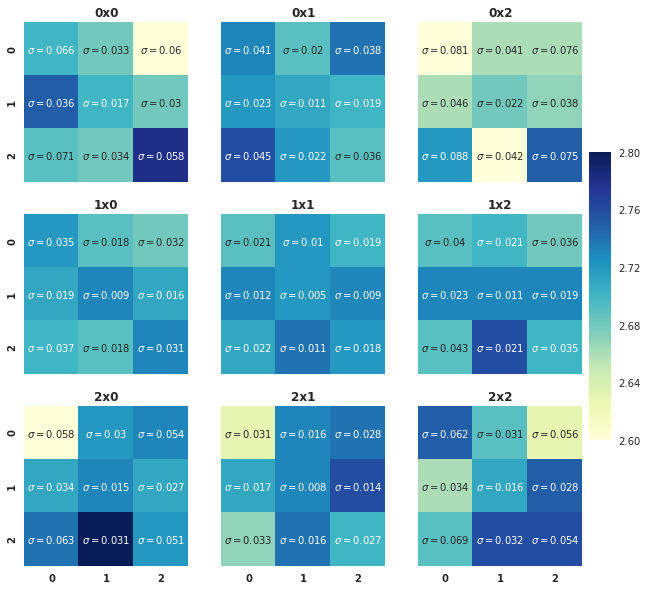

In [14]:
# hasn't been modularized, but generates the graphic for S values. 
a_sval = np.loadtxt('S_Values.csv',dtype = "float", usecols = (1))
a_test = np.loadtxt('S_Values.csv',dtype = "str")
a_svalerr = np.loadtxt('S_Values.csv',dtype = "float", usecols = (2))
#print(a_test)
a_s = a_sval
title = []
a_subplot = [0]*9
a_errors = [0]*9
a_errnum = [0]*9
for i in range(3):
    for j in range(3):
        title.append(np.str(i)+'x'+np.str(j))
fig, axn = plt.subplots(3, 3, sharey=True, sharex = True, figsize = (10,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
plt.rcParams["font.family"] = "Times New Roman"
label = [0]*81
for i in range(81):
    #label[i] = np.str(np.around(a_s[i],2)) + "+\-" + np.str(np.around(a_svalerr[i],2))
    label[i] = '$\sigma = $' +  np.str(np.around(a_svalerr[i],3))
print(label)
for i in range(9):
    a_subplot[i] = np.row_stack(((a_s[i*9:9*i+3]),a_s[i*9+3:9*i+6],a_s[i*9+6:9*i+9]))
    a_errors[i] = np.row_stack(((label[i*9:9*i+3]),label[i*9+3:9*i+6],label[i*9+6:9*i+9]))
    a_errnum[i] = np.row_stack(((a_svalerr[i*9:9*i+3]),a_svalerr[i*9+3:9*i+6],a_svalerr[i*9+6:9*i+9]))
    #print(a_subplot[i],i)
#print(a_subplot)
#print(a_errors)

for i, ax in enumerate(axn.flat):
    sns.heatmap(np.around(a_subplot[i],2), annot=a_errors[i], fmt='',annot_kws={"size": 10}, ax=ax,cbar=i == 0,
                vmin=2.60, vmax=2.80,       # these min & maxes should change when we get a max of 2.82
                cbar_ax=None if i else cbar_ax,cmap="YlGnBu" ) # feel free to change the color
    ax.set_title(title[i],fontweight="bold")
    for label in ax.get_yticklabels():
        label.set_weight("bold")
    for label in ax.get_xticklabels():
        label.set_weight("bold")
plt.savefig('tomography.eps', bbox_inches='tight')
plt.show()

In [15]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(0, 2, 3)
y = np.linspace(0, 2, 3)

X, Y = np.meshgrid(x, y)
Z = a_subplot[0]
sigma = a_errnum[0]
print(sigma)

[[0.06567912 0.03296215 0.0601589 ]
 [0.03643963 0.01719373 0.03018655]
 [0.07143603 0.03369152 0.05814026]]


In [16]:
print(X[1])
#print(x[1])
test1, test2 = np.meshgrid(x[1],y[1])
print(test1)
print(X[1,2,2])

[0. 1. 2.]
[[1.]]


IndexError: too many indices for array

In [ ]:
print(len(a_subplot))

In [ ]:
x = np.empty((3,9))
y = np.empty((3,9))
Z = np.empty((3,3,9))
sigma = np.empty((3,3,9))
X = np.empty((3,3,9))
Y = np.empty((3,3,9))
for i in range(3):
    x[:,i] = np.linspace(i*3, 2+3*i, 3)
    y[:,i] = np.linspace(i*3, 2+3*i, 3)
    fill1, fill2 = np.meshgrid(x[:,i], y[:,i])
    X[:,:,i]= fill1
    Y[:,:,i]= fill2
    Z[:,:,i] = a_subplot[i]
    print(Z[:,:,i])
    sigma[:,:,i] = a_errnum[i]
    

In [ ]:
z = np.empty((9,9))
for i in range(9):
    z[:,i] = Z[:,:,i].flatten()
print(z[i])

In [ ]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
for i in range(9):
    ax.scatter(X[:,:,i], Y[:,:,i], Z[:,:,i], s = 40, marker = 'o', c = z[i],
                cmap='YlGnBu', edgecolor='none' )


#ax.scatter(X, Y, Z_poserr, 
#                cmap='YlGnBu', edgecolor='none', alpha = 0.5)
#ax.scatter(X, Y, Z_negerr, 
#                cmap='YlGnBu', edgecolor='none', alpha = 0.5)
ax.set_title('surface');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.view_init(20, 55)
